# Cleaned AHP Calculation


In [79]:
import pandas as pd
import numpy as np
from scipy.linalg import eig

# Random Index (RI) values based on matrix size (1 to 10 criteria)
RI = {1: 0.0, 2: 0.0, 3: 0.58, 4: 0.90, 5: 1.12, 6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49}

default_ci_threshold = 1.5

# Response scale AHP (saaty scale)
response_scale_ahp = {
    "A mutlak lebih penting dibandingkan B": 9,
    "A sangat lebih penting dibandingkan B": 7,
    "A cukup lebih penting dibandingkan B": 5,
    "A sedikit lebih penting dibandingkan B": 3,
    "Sama pentingnya": 1,
    "B sedikit lebih penting dibandingkan A": 1/3,
    "B cukup lebih penting dibandingkan A": 1/5,
    "B sangat lebih penting dibandingkan A": 1/7,
    "B mutlak lebih penting dibandingkan A": 1/9
}

balanced_scale = lambda x: (9 + x)/(11-x)


# Response scale balanced
response_scale_balanced = {
    "A mutlak lebih penting dibandingkan B": balanced_scale(9),
    "A sangat lebih penting dibandingkan B": balanced_scale(7),
    "A cukup lebih penting dibandingkan B": balanced_scale(5),
    "A sedikit lebih penting dibandingkan B": balanced_scale(3),
    "Sama pentingnya": 1.0,
    "B sedikit lebih penting dibandingkan A": 1/balanced_scale(3),
    "B cukup lebih penting dibandingkan A": 1/balanced_scale(5),
    "B sangat lebih penting dibandingkan A": 1/balanced_scale(7),
    "B mutlak lebih penting dibandingkan A": 1/balanced_scale(9),
}

# Criteria definitions
ppt_criteria = ["People", "Process", "Technology"]
ppt_criteria_pairs = [
    "3. A: People. B: Process",
    "4. A: People. B: Technology",
    "5. A: Process. B: Technology"
]

people_criteria = [
    "Dukungan manajemen senior",
    "Alokasi sumber daya",
    "Kompatibilitas Teknologi",
    "Perubahan manajemen dan Adaptasi User"
]

people_criteria_pairs = [
    f"7. A: {people_criteria[0]}. B: {people_criteria[1]}",
    f"8. A: {people_criteria[0]}. B: {people_criteria[2]}",
    f"9. A: {people_criteria[0]}. B: {people_criteria[3]}",
    f"10. A: {people_criteria[1]}. B: {people_criteria[2]}",
    f"11. A: {people_criteria[1]}. B: {people_criteria[3]}",
    f"12. A: {people_criteria[2]}. B: {people_criteria[3]}"
]

process_criteria = [
    "Rekayasa ulang proses bisnis",
    "Kebutuhan sistem yang jelas",
    "Standar operasional yang jelas",
    "Mitigasi dan manajemen risiko"
]

process_criteria_pairs = [
    f"14. A: {process_criteria[0]}. B: {process_criteria[1]}",
    f"15. A: {process_criteria[0]}. B: {process_criteria[2]}",
    f"16. A: {process_criteria[0]}. B: {process_criteria[3]}",
    f"17. A: {process_criteria[1]}. B: {process_criteria[2]}",
    f"18. A: {process_criteria[1]}. B: {process_criteria[3]}",
    f"19. A: {process_criteria[2]}. B: {process_criteria[3]}"
]

technology_criteria = [
    "Keamanan yang kuat",
    "Skalabilitas infrastruktur IT",
    "Integrasi Sistem",
    "Performa dan kecepatan sistem"
]

technology_criteria_pairs = [
    f"21. A: {technology_criteria[0]}. B: {technology_criteria[1]}",
    f"22. A: {technology_criteria[0]}. B: {technology_criteria[2]}",
    f"23. A: {technology_criteria[0]}. B: {technology_criteria[3]}",
    f"24. A: {technology_criteria[1]}. B: {technology_criteria[2]}",
    f"25. A: {technology_criteria[1]}. B: {technology_criteria[3]}",
    f"26. A: {technology_criteria[2]}. B: {technology_criteria[3]}"
]

# Function to build pairwise comparison matrix
def build_matrix(row, pairs, criteria, response_scale):
    n = len(criteria)
    matrix = np.ones((n, n))  # Start with identity matrix
    for i, crit_a in enumerate(criteria):
        for j, crit_b in enumerate(criteria):
            if i < j:
                pairwise_key = next(
                    (pair for pair in pairs if f"A: {crit_a}. B: {crit_b}" in pair), None
                )
                if pairwise_key and pairwise_key in row and row[pairwise_key] in response_scale:
                    weight = response_scale[row[pairwise_key]]
                    matrix[i, j] = weight
                    matrix[j, i] = 1 / weight
    return matrix

# Calculate Consistency Index (CI)
def calculate_ci(matrix):
    n = matrix.shape[0]
    eigvals, _ = eig(matrix)
    lambda_max = max(eigvals.real)
    ci = (lambda_max - n) / (n - 1)
    return ci

# Clean data based on CI threshold
def clean_data(data, pairs, criteria, response_scale=response_scale_ahp, threshold=default_ci_threshold):
    valid_responses = []
    for _, row in data.iterrows():
        matrix = build_matrix(row, pairs, criteria, response_scale)
        ci = calculate_ci(matrix)
        cr = ci / RI[len(criteria)] if len(criteria) in RI else float('inf')
        print(f"R{row['No.']},{cr:.8f}")
        if cr <= threshold:
            valid_responses.append(row)
        # else:
        #     print(f"Response {row['Response ID']} from {row['1. Profil Responden']} has a CR of {cr}")
    return pd.DataFrame(valid_responses)

# Calculate priority vector
def calculate_priority_vector(matrix):
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)
    priority_vector = normalized_matrix.mean(axis=1)
    return priority_vector

In [2]:
# Main Script
file_path = "~/Downloads/export-core_banking_system_csf_survey-2024-12-01-08-19-25.csv"
data = pd.read_csv(file_path)
data = data.applymap(lambda x: x.replace('\t', ' ') if isinstance(x, str) else x)
data = data.rename(columns={
    '10. A: Alokasi sumber daya . B: Kompatibilitas Teknologi': '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
    '11. A: Alokasi sumber daya . B: Perubahan manajemen dan Adaptasi User': '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
    '12. A: Kompatibilitas Teknologi  . B: Perubahan manajemen dan Adaptasi User': '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User',
    })


In [3]:
unique_values = data['21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT'].unique()
unique_values

array(['B sangat lebih penting dibandingkan A',
       'A cukup lebih penting dibandingkan B',
       'A sangat lebih penting dibandingkan B',
       'B cukup lebih penting dibandingkan A'], dtype=object)

In [4]:
data.columns

Index(['No.', 'Response ID', 'Timestamp', 'Finished', 'Survey ID',
       'Formbricks ID (internal)', 'User ID', 'Notes', 'Tags', 'url', 'source',
       'country', 'userAgent - os', 'userAgent - device',
       'userAgent - browser', '1. Profil Responden',
       '2. Apa pekerjaan anda dan berikan penjelasan singkat pekerjaan anda',
       '3. A: People. B: Process', '4. A: People. B: Technology',
       '5. A: Process. B: Technology', '6. People',
       '7. A: Dukungan manajemen senior. B: Alokasi sumber daya',
       '8. A: Dukungan manajemen senior. B: Kompatibilitas Teknologi',
       '9. A: Dukungan manajemen senior. B: Perubahan manajemen dan Adaptasi User',
       '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
       '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
       '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User',
       '13. Process',
       '14. A: Rekayasa ulang proses bisnis. B: Kebutuhan sistem yang jela

## Saaty Scale


In [5]:
# Clean and process PPT level
ppt_cleaned_data = clean_data(data, ppt_criteria_pairs, ppt_criteria)
print("ppt_cleaned_data length", len(ppt_cleaned_data))

R1,0.15755759
R2,3.80787711
R3,0.37559409
R4,4.77051402
R5,3.80787711
R6,0.44883024
R7,2.75862069
R8,0.25412025
R9,0.15755759
R10,0.20105753
R11,4.26815732
R12,3.80787711
R13,0.25412025
R14,0.37559409
R15,0.25412025
R16,0.25412025
R17,0.37559409
R18,0.25412025
R19,0.52350875
ppt_cleaned_data length 13


In [6]:
people_cleaned_data = clean_data(data, people_criteria_pairs, people_criteria)
print("people_cleaned_data length", len(people_cleaned_data))

R1,0.31578153
R2,0.45747204
R3,1.68365796
R4,1.43646966
R5,2.59862373
R6,1.01320185
R7,1.00892588
R8,2.17299659
R9,0.27257892
R10,0.31578153
R11,0.43799317
R12,0.38620091
R13,0.29596320
R14,0.33047082
R15,0.31578153
R16,1.43269620
R17,0.36696385
R18,0.37915399
R19,0.31578153
people_cleaned_data length 16


In [7]:
process_cleaned_data = clean_data(data, process_criteria_pairs, process_criteria)
print("process_cleaned_data length", len(process_cleaned_data))


R1,0.45747204
R2,1.86677622
R3,1.21392529
R4,1.43269620
R5,2.59862373
R6,0.19943730
R7,1.87032326
R8,1.23213104
R9,1.27929200
R10,0.39320369
R11,1.61704711
R12,2.42216669
R13,0.37915399
R14,0.37915399
R15,1.68174010
R16,1.43646966
R17,0.32470149
R18,1.42893486
R19,0.37915399
process_cleaned_data length 13


In [8]:
technology_cleaned_data = clean_data(data, technology_criteria_pairs, technology_criteria)
print("technology_cleaned_data length", len(technology_cleaned_data))

R1,0.37915399
R2,0.19795571
R3,0.38307765
R4,1.43382618
R5,0.37915399
R6,0.31578153
R7,0.26623236
R8,2.51391515
R9,1.00741019
R10,0.27257892
R11,1.43269620
R12,0.26332411
R13,0.21678997
R14,0.38620091
R15,0.23749951
R16,0.25306725
R17,0.26761102
R18,0.38620091
R19,0.38620091
technology_cleaned_data length 18


In [9]:
ppt_priority_vectors = [
    calculate_priority_vector(build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_ahp))
    for _, row in ppt_cleaned_data.iterrows()
]

# Example: Calculate priority for People sub-criteria
people_priority_vectors = [
    calculate_priority_vector(build_matrix(row, people_criteria_pairs, people_criteria,response_scale_ahp))
    for _, row in people_cleaned_data.iterrows()
]

# Calculate priority vectors for Process and Technology sub-criteria
process_priority_vectors = [
    calculate_priority_vector(build_matrix(row, process_criteria_pairs, process_criteria,response_scale_ahp))
    for _, row in process_cleaned_data.iterrows()
]

technology_priority_vectors = [
    calculate_priority_vector(build_matrix(row, technology_criteria_pairs, technology_criteria,response_scale_ahp))
    for _, row in technology_cleaned_data.iterrows()
]

# Output results for all levels with formatted criteria and scores
print("PPT Priority Vectors:")
print("cleaned sample size", len(ppt_cleaned_data))
ppt_priority_mean = np.mean(ppt_priority_vectors, axis=0)
for criteria, score in zip(ppt_criteria, ppt_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nPeople Priority Vectors:")
print("cleaned sample size", len(people_cleaned_data))
people_priority_mean = np.mean(people_priority_vectors, axis=0)
for criteria, score in zip(people_criteria, people_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nProcess Priority Vectors:")
print("cleaned sample size", len(process_cleaned_data))
process_priority_mean = np.mean(process_priority_vectors, axis=0)
for criteria, score in zip(process_criteria, process_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nTechnology Priority Vectors:")
print("cleaned sample size", len(technology_cleaned_data))
technology_priority_mean = np.mean(technology_priority_vectors, axis=0)
for criteria, score in zip(technology_criteria, technology_priority_mean):
    print(f"{criteria}: {score:.4f}")

[[0.74468085 0.53846154 0.80645161]
 [0.10638298 0.07692308 0.03225806]
 [0.14893617 0.38461538 0.16129032]]
[[0.77777778 0.46666667 0.85964912]
 [0.11111111 0.06666667 0.01754386]
 [0.11111111 0.46666667 0.12280702]]
[[0.65217391 0.80645161 0.33333333]
 [0.13043478 0.16129032 0.55555556]
 [0.2173913  0.03225806 0.11111111]]
[[0.71428571 0.45454545 0.80645161]
 [0.14285714 0.09090909 0.03225806]
 [0.14285714 0.45454545 0.16129032]]
[[0.16129032 0.14893617 0.38461538]
 [0.80645161 0.74468085 0.53846154]
 [0.03225806 0.10638298 0.07692308]]
[[0.74468085 0.84       0.55555556]
 [0.10638298 0.12       0.33333333]
 [0.14893617 0.04       0.11111111]]
[[0.1627907  0.14893617 0.46666667]
 [0.81395349 0.74468085 0.46666667]
 [0.02325581 0.10638298 0.06666667]]
[[0.77777778 0.85964912 0.46666667]
 [0.11111111 0.12280702 0.46666667]
 [0.11111111 0.01754386 0.06666667]]
[[0.77777778 0.85365854 0.53846154]
 [0.11111111 0.12195122 0.38461538]
 [0.11111111 0.02439024 0.07692308]]
[[0.12195122 0.1111

## Balanced Scale


In [54]:
balanced_scale_threshold = 0.2

In [55]:
# Clean and process PPT level
ppt_cleaned_data = clean_data(data, ppt_criteria_pairs, ppt_criteria, response_scale_balanced, balanced_scale_threshold)
print("ppt_cleaned_data length", len(ppt_cleaned_data))

R1,0.00911240
R2,1.41500247
R3,0.18738067
R4,3.37331569
R5,1.41500247
R6,0.16164632
R7,0.65681445
R8,0.06922400
R9,0.00911240
R10,0.08614938
R11,2.24815061
R12,1.41500247
R13,0.06922400
R14,0.18738067
R15,0.06922400
R16,0.06922400
R17,0.18738067
R18,0.06922400
R19,0.36740673
ppt_cleaned_data length 12


In [56]:
people_cleaned_data = clean_data(data, people_criteria_pairs, people_criteria, response_scale_balanced, balanced_scale_threshold)
print("people_cleaned_data length", len(people_cleaned_data))

R1,0.12617475
R2,0.27721197
R3,0.71962861
R4,0.52472013
R5,1.11687624
R6,0.23465834
R7,0.22079036
R8,0.76910536
R9,0.07084348
R10,0.12617475
R11,0.32870052
R12,0.20146916
R13,0.14415157
R14,0.10779353
R15,0.12617475
R16,0.51162269
R17,0.25254722
R18,0.18518519
R19,0.12617475
people_cleaned_data length 8


In [57]:
process_cleaned_data = clean_data(data, process_criteria_pairs, process_criteria, response_scale_balanced, balanced_scale_threshold)
print("process_cleaned_data length", len(process_cleaned_data))


R1,0.27721197
R2,0.56621749
R3,0.37192082
R4,0.51162269
R5,1.11687624
R6,0.06733585
R7,0.54403563
R8,0.38957279
R9,0.35823823
R10,0.21754585
R11,0.82877468
R12,1.15114906
R13,0.18518519
R14,0.18518519
R15,0.69128297
R16,0.52472013
R17,0.18559729
R18,0.49825029
R19,0.18518519
process_cleaned_data length 5


In [58]:
technology_cleaned_data = clean_data(data, technology_criteria_pairs, technology_criteria, response_scale_balanced, balanced_scale_threshold)
print("technology_cleaned_data length", len(technology_cleaned_data))

R1,0.18518519
R2,0.02306880
R3,0.22244648
R4,0.54910661
R5,0.18518519
R6,0.12617475
R7,0.09672935
R8,1.23775813
R9,0.43755284
R10,0.07084348
R11,0.51162269
R12,0.11544669
R13,0.02681491
R14,0.20146916
R15,0.06048638
R16,0.06747367
R17,0.04916215
R18,0.20146916
R19,0.20146916
technology_cleaned_data length 11


In [ ]:
ppt_priority_vectors = [
    calculate_priority_vector(build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced))
    for _, row in ppt_cleaned_data.iterrows()
]

# Example: Calculate priority for People sub-criteria
people_priority_vectors = [
    calculate_priority_vector(build_matrix(row, people_criteria_pairs, people_criteria,response_scale_balanced))
    for _, row in people_cleaned_data.iterrows()
]

# Calculate priority vectors for Process and Technology sub-criteria
process_priority_vectors = [
    calculate_priority_vector(build_matrix(row, process_criteria_pairs, process_criteria,response_scale_balanced))
    for _, row in process_cleaned_data.iterrows()
]

technology_priority_vectors = [
    calculate_priority_vector(build_matrix(row, technology_criteria_pairs, technology_criteria,response_scale_balanced))
    for _, row in technology_cleaned_data.iterrows()
]

[[0.59574468 0.54545455 0.62025316]
 [0.14893617 0.13636364 0.11392405]
 [0.25531915 0.31818182 0.26582278]]
[[0.66666667 0.44444444 0.76190476]
 [0.16666667 0.11111111 0.04761905]
 [0.16666667 0.44444444 0.19047619]]
[[0.47727273 0.62025316 0.31034483]
 [0.20454545 0.26582278 0.48275862]
 [0.31818182 0.11392405 0.20689655]]
[[0.53846154 0.41176471 0.62025316]
 [0.23076923 0.17647059 0.11392405]
 [0.23076923 0.41176471 0.26582278]]
[[0.26582278 0.25531915 0.31818182]
 [0.62025316 0.59574468 0.54545455]
 [0.11392405 0.14893617 0.13636364]]
[[0.59574468 0.70588235 0.48275862]
 [0.14893617 0.17647059 0.31034483]
 [0.25531915 0.11764706 0.20689655]]
[[0.27906977 0.25531915 0.44444444]
 [0.65116279 0.59574468 0.44444444]
 [0.06976744 0.14893617 0.11111111]]
[[0.66666667 0.76190476 0.44444444]
 [0.16666667 0.19047619 0.44444444]
 [0.16666667 0.04761905 0.11111111]]
[[0.66666667 0.73684211 0.54545455]
 [0.16666667 0.18421053 0.31818182]
 [0.16666667 0.07894737 0.13636364]]
[[0.18421053 0.1666

In [81]:
# Output results for all levels with formatted criteria and scores
print("PPT Priority Vectors:")
print("cleaned sample size", len(ppt_cleaned_data))
ppt_priority_mean = np.mean(ppt_priority_vectors, axis=0)
for criteria, score in zip(ppt_criteria, ppt_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nPeople Priority Vectors:")
print("cleaned sample size", len(people_cleaned_data))
people_priority_mean = np.mean(people_priority_vectors, axis=0)
for criteria, score in zip(people_criteria, people_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nProcess Priority Vectors:")
print("cleaned sample size", len(process_cleaned_data))
process_priority_mean = np.mean(process_priority_vectors, axis=0)
for criteria, score in zip(process_criteria, process_priority_mean):
    print(f"{criteria}: {score:.4f}")

print("\nTechnology Priority Vectors:")
print("cleaned sample size", len(technology_cleaned_data))
technology_priority_mean = np.mean(technology_priority_vectors, axis=0)
for criteria, score in zip(technology_criteria, technology_priority_mean):
    print(f"{criteria}: {score:.4f}")

PPT Priority Vectors:
cleaned sample size 12
People: 0.4877
Process: 0.3389
Technology: 0.1734

People Priority Vectors:
cleaned sample size 8
Dukungan manajemen senior: 0.2487
Alokasi sumber daya: 0.1534
Kompatibilitas Teknologi: 0.0691
Perubahan manajemen dan Adaptasi User: 0.5288

Process Priority Vectors:
cleaned sample size 5
Rekayasa ulang proses bisnis: 0.3121
Kebutuhan sistem yang jelas: 0.4289
Standar operasional yang jelas: 0.1338
Mitigasi dan manajemen risiko: 0.1251

Technology Priority Vectors:
cleaned sample size 11
Keamanan yang kuat: 0.1215
Skalabilitas infrastruktur IT: 0.1569
Integrasi Sistem: 0.5384
Performa dan kecepatan sistem: 0.1832


In [61]:
matrixes = []

for _, row in ppt_cleaned_data.iterrows():
    print(row["1. Profil Responden"])
    matrix = build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced)
    matrixes.append(matrix)
    print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
print("average")
print(avg_matrix)

normalized_matrix = avg_matrix / avg_matrix.sum(axis=0)

print("normalized_matrix")
print(normalized_matrix)

Amelia, Sinaga, PT BPR Buana Agribisnis
[[1.         4.         2.33333333]
 [0.25       1.         0.42857143]
 [0.42857143 2.33333333 1.        ]]
Eko, ., BPR Mitra Sejahtera Lestari
[[1.   4.   4.  ]
 [0.25 1.   0.25]
 [0.25 4.   1.  ]]
Adi, Junianto, PT BPR Logo Karo asri
[[1.         2.33333333 1.5       ]
 [0.42857143 1.         2.33333333]
 [0.66666667 0.42857143 1.        ]]
Jojor, Simanjuntak, PT BPR Logo Karo Asri
[[1.         2.33333333 2.33333333]
 [0.42857143 1.         0.42857143]
 [0.42857143 2.33333333 1.        ]]
nan
[[1.         0.42857143 2.33333333]
 [2.33333333 1.         4.        ]
 [0.42857143 0.25       1.        ]]
Dede, Gunawan, PT BPR Tata Asia
[[1.         4.         2.33333333]
 [0.25       1.         1.5       ]
 [0.42857143 0.66666667 1.        ]]
Rizal, ., PD BPR Bank Daerah Kabupaten Kediri
[[1.         0.42857143 4.        ]
 [2.33333333 1.         4.        ]
 [0.25       0.25       1.        ]]
Idrus, Afandi, PT Dimensi Kreasi Nusantara
[[1.   4.  

In [62]:
def build_matrix(row, pairs, criteria, response_scale):
    n = len(criteria)
    matrix = np.ones((n, n))  # Start with identity matrix
    for i, crit_a in enumerate(criteria):
        for j, crit_b in enumerate(criteria):
            if i < j:
                # print(i,j)
                pairwise_key = next(
                    (pair for pair in pairs if f"A: {crit_a}. B: {crit_b}" in pair), None
                )
                # print(pairwise_key)
                # print(pairwise_key in row)
                # print(row[pairwise_key])
                if pairwise_key and pairwise_key in row:
                    if row[pairwise_key] in response_scale:
                        weight = response_scale[row[pairwise_key]]
                    else: # fallback to 1 for empty answer
                        weight = 1

                    matrix[i, j] = weight
                    matrix[j, i] = 1 / weight
    return matrix


In [70]:
np.set_printoptions(precision=5, suppress=True)

In [71]:
matrixes = []

for _, row in ppt_cleaned_data.iterrows():
    matrix = build_matrix(row, ppt_criteria_pairs, ppt_criteria,response_scale_balanced)
    matrixes.append(matrix)
    # print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((3, 3), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = ci / RI[len(ppt_criteria)]
print(cr)

12
[[     1.         438.85714 424947.35802]
 [     0.00228      1.        1536.     ]
 [     0.           0.00065      1.     ]]
[[ 1.       7.59931 75.18163]
 [ 0.13159  1.      11.538  ]
 [ 0.0133   0.08667  1.     ]]
0.0013143680267653224
0.0022661517702850385


## Process Pairwise


In [72]:
matrixes = []

for _, row in process_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    matrix = build_matrix(row, process_criteria_pairs, process_criteria,response_scale_balanced)
    matrixes.append(matrix)
    # print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = ci / RI[len(process_criteria)]
print(cr)

5
[[   1.         0.14583   37.33333  348.44444]
 [   6.85714    1.      2304.       348.44444]
 [   0.02679    0.00043    1.         0.66667]
 [   0.00287    0.00287    1.5        1.     ]]
[[1.      0.61797 2.47186 4.32049]
 [1.61821 1.      6.9282  4.32049]
 [0.40455 0.14434 1.      0.9036 ]
 [0.23146 0.23146 1.10668 1.     ]]
0.0231993715105047
0.025777079456116334


## People Pairwise


In [78]:
matrixes = []

for _, row in people_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    matrix = build_matrix(row, people_criteria_pairs, people_criteria,response_scale_balanced)
    matrixes.append(matrix)
    # print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    end_matrix = np.multiply(end_matrix, matrix)
    normalized_matrix = matrix / matrix.sum(axis=0)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = ci / RI[len(people_criteria)]
print(cr)

8
[[     1.       13008.59259  13008.59259      0.00008]
 [     0.00008      1.       65536.           0.00001]
 [     0.00008      0.00002      1.           0.     ]
 [ 13008.59259 112896.      746496.           1.     ]]
[[ 1.      10.67966 10.67966  0.09364]
 [ 0.09364  1.      16.       0.05455]
 [ 0.09364  0.0625   1.       0.03402]
 [10.67966 18.3303  29.39388  1.     ]]
0.420022625151117
0.4666918057234633


## Technology Pairwise


In [80]:
matrixes = []

for _, row in technology_cleaned_data.iterrows():
    # print(row["1. Profil Responden"])
    # print(row)
    matrix = build_matrix(row, technology_criteria_pairs, technology_criteria,response_scale_balanced)
    matrixes.append(matrix)
    # print(matrix)


avg_matrix = np.mean(matrixes, axis=0)
# print(avg_matrix)
# res = [sum(idx) / len(idx) for idx in zip(*test_list)]


end_matrix = np.ones((4, 4), dtype=int)

print(len(matrixes))

for  matrix in matrixes:
    # print(matrix)
    end_matrix = np.multiply(end_matrix, matrix)

    # print(matrix.sum(axis=0))
    normalized_matrix = matrix / matrix.sum(axis=0)
    # print(normalized_matrix)

end_matrix_meaned =  end_matrix ** (1/len(matrix))

print(end_matrix)
print(end_matrix_meaned)

ci = calculate_ci(end_matrix_meaned)
print(ci)
# cr = ci / RI[len(technology_criteria_pairs)] if len(technology_criteria_pairs) in RI else float('inf')
cr = ci / RI[len(technology_criteria)]
print(cr)

11
[[       1.             0.00031        0.             0.00152]
 [    3252.14815        1.             0.             0.0506 ]
 [15116544.      21233664.             1.       1427228.44444]
 [     658.28571       19.76132        0.             1.     ]]
[[ 1.       0.13242  0.01604  0.19742]
 [ 7.55166  1.       0.01473  0.47429]
 [62.35383 67.88225  1.      34.56395]
 [ 5.06528  2.1084   0.02893  1.     ]]
0.1516003928247649
0.16844488091640544


pembuka 
anggota kel
latar belakang
pertanyaan penelitian
manfaat, state of the art
cbs
csf studi literatur
csf yg kita pilih
alur penelitian
hasil kuisioner (top 6 csf)
thank you slide

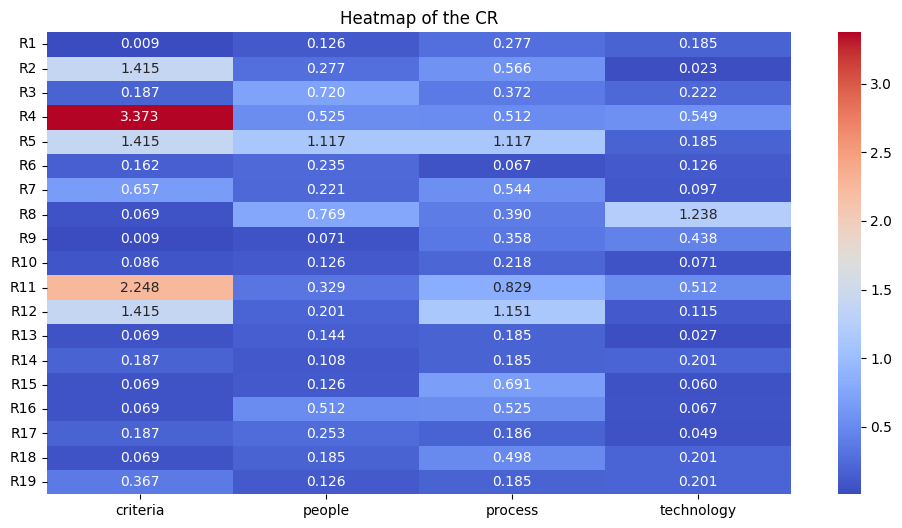

In [85]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    'R1': [0.009, 0.126, 0.277, 0.185],
    'R2': [1.415, 0.277, 0.566, 0.023],
    'R3': [0.187, 0.720, 0.372, 0.222],
    'R4': [3.373, 0.525, 0.512, 0.549],
    'R5': [1.415, 1.117, 1.117, 0.185],
    'R6': [0.162, 0.235, 0.067, 0.126],
    'R7': [0.657, 0.221, 0.544, 0.097],
    'R8': [0.069, 0.769, 0.390, 1.238],
    'R9': [0.009, 0.071, 0.358, 0.438],
    'R10': [0.086, 0.126, 0.218, 0.071],
    'R11': [2.248, 0.329, 0.829, 0.512],
    'R12': [1.415, 0.201, 1.151, 0.115],
    'R13': [0.069, 0.144, 0.185, 0.027],
    'R14': [0.187, 0.108, 0.185, 0.201],
    'R15': [0.069, 0.126, 0.691, 0.060],
    'R16': [0.069, 0.512, 0.525, 0.067],
    'R17': [0.187, 0.253, 0.186, 0.049],
    'R18': [0.069, 0.185, 0.498, 0.201],
    'R19': [0.367, 0.126, 0.185, 0.201]
}

# Create DataFrame
df = pd.DataFrame(data, index=['criteria', 'people', 'process', 'technology'])

df_transposed = df.T

# Plot the heatmap with transposed data
plt.figure(figsize=(12, 6))  # Make the plot wider
sns.heatmap(df_transposed, annot=True, cmap='coolwarm', fmt='.3f', cbar=True)
plt.title("Heatmap of the CR")
plt.show()


Terdapat data dari banyak sumber yang berbeda​

Data pokok nasabah, rekening, dan transaksi keuangan dikelola di CBS, pengajuan pembukaan rekening dikelola di CRM, pengajuan dan analisis kredit di dikelola di LOS, dan data AML-CFT dikelola pada sistem AML​

Banyak kebutuhan data internal dan eksternal​

Waktu berjalan banyak kebutuhan pelaporan data pada regulator, baik harian, mingguan, bulanan, dan tahunan dengan format yang determined. Meningkatnya kebutuhan internal untuk melakukan analisis bisnis bersumber dari data historikal yang telah dimiliki​

Belum ada agregasi data dan monitoring kualitas data​

Alur integrasi data antar sistem bersifat satu arah, belum ada mekanisme pengkinian data serta pemantauan kualitas data di tengah adanya risiko atas kualitas data yang tidak baik​

Dorongan regulator terkait pengelolaan kualitas data​

POJK 8/2023 tentang Penerapan Program APUPPT-PPPSPM mewajibkan lembaga jasa keuangan untuk melakukan pengkinian data nasabah secara regular​

Risiko Reputasi​

Misinformasi dalam data dapat mengakibatkan kepercayaan perusahaan dari nasabah maupun regulator akibat data tidak akurat.​

Risiko Kesalahan Pelaporan​

Data yang salah dilaporkan dalam pelaporan berisiko untuk mendapatkan sanksi dari regulator​

Risiko Finansial​
Kesalahan yang berkaitan dengan data nasabah berisiko untuk menimbulkan kerugian finansial akibat ganti rugi yang disebabkan oleh misinformasi tersebut. Sanksi regulator terkait kesalahan pelaporan juga termasuk dengan sanksi berupa denda​

Risiko Strategis​

Insight yang diambil oleh manajemen dari data dengan kualitas yang buruk berdampak pada kesalahan strategi yang diambil berdasarkan sumber data yang tidak valid​

Bagaimana tingkat kematangan manajemen kualitas data pada PT XYZ ​

Bagaimana cara meningkatkan kualitas manajemen data pada PT XYZ?​

Informal communication about data quality between IT and other divisions. IT support handles most data quality issues without a formal strategy. No dedicated data stewardship; responsibilities are ad hoc.

Best practices for data quality are shared informally.
No formal workgroup for data governance or guiding principles in development.

"Certification process for trusted data sources is still not defined."
"Master data reference sets have been identified and are managed, but further formalization is needed."
"No formal process for overseeing the management of exchange standards."
"No Data Standards Oversight Board exists."

"Data controls deployed across the enterprise."
"Participants publish data quality measurements."
"Data quality management practices are transparent."

"Failures reacted to reactively, with no coordination with business processes."
"Root causes unidentified, errors repeated."
"Errors tracked for incompleteness and invalid syntax."
"Basic root cause analysis via data quality rules."

"Tools for assessing objective data quality not available."
"Data parsing, standardization, and cleansing available."
"Data quality technology for matching and linking not available."

"Implement tools for assessing objective data quality."
"Establish data quality technology for locating, matching, and linking data."
"Define standardized procedures for using data quality tools to assess and improve data quality."
"Implement business rule-based techniques for data validation."
"Standardize technology components for data validation, certification, assurance, and reporting across the organization."
"Ensure technology components are standardized at both the service and implementation layers."

"Implement a Master Data Management (MDM) solution to formalize and manage master data concepts."
"Develop and define a clear taxonomy for data standards across the organization and ensure it is endorsed and widely adopted."
"Integrate conformance checks for data standards via a technical structure driven by organizational policies to ensure consistent data quality and standardization."
"Implement automation to enable straight-through processing for data, ensuring data consistency and standardization at every step."
